In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
from collections import Counter
import polars as pl
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

## Data Loading

In [3]:
# years we have data for
years = ('2020-2021',
         '2021-2022',
         '2022-2023',
         '2023-2024',
         '2024-2025')

In [4]:
columns = ("timestamp", "institution", "location", "subject_area",
           "review_date", "url", "rank", "appointment", "last_update",
           "notes", "number_applied", "mod_flag")

In [5]:
data_dir = Path("data")
dfs = {year: pl.read_excel(data_dir / f"ecoevo-{year}.xlsx", read_options=dict(skip_rows=2, column_names=columns)) for year in years}

In [6]:
# Look at the label counts for TT jobs and other appointments
Counter(itertools.chain(*[[title for title in df['appointment'] if title is not None] for df in dfs.values()]))

Counter({'Tenure Track': 2242,
         'Tenure Stream': 1247,
         'Fixed Term': 333,
         'Permanent Non-Academic': 242,
         'Non-TS Academic': 142,
         'Permanent Non-TT': 132,
         'Government': 75,
         'Non-Profit Research Organization': 37,
         'Museum': 23,
         'NGO': 21,
         'Fixed Term Academic': 14,
         'Industry': 12,
         'Asst Prof': 5,
         'Non-Tenure Track': 3,
         'Permanent': 3,
         'Non-Tenure Stream Academic': 3,
         'Non-TT': 2,
         'Postdoc to TT': 2,
         'Non-TS Faculty': 2,
         'Fixed-Term Academic': 2,
         'Tenure Trackw+': 1,
         ' ': 1,
         'Unit Leader': 1,
         'Adjunct Asst Prof': 1,
         'Visiting Asst Prof': 1,
         'Open-length Term': 1,
         'fixed Term': 1,
         'Rank Open': 1,
         'Asst / Assoc Prof': 1,
         'Staff Associate': 1,
         'Non Tenure Track': 1,
         'STEM-High School': 1,
         'Researcher': 1,
    

In [7]:
# Manually chosen labels
tt_labels = ('Tenure Track', 'Tenure Stream', 'Asst / Assoc Prof', 'Tenure Trackw+', 'Asst Prof')

In [8]:
# List of US states + DC for subsetting US jobs
states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 
    'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 
    'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 
    'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 
    'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 
    'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 
    'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 
    'Wisconsin', 'Wyoming',  'District of Columbia',
]

In [9]:
def combine_and_clean_data(dfs, filters=None):
    dfs_cleaned = dict()
    for year, df in dfs.items():
        start_year, end_year = tuple(map(int, year.split('-')))
        dfy = (df
               .sort('timestamp')
               .filter(pl.col('timestamp').is_not_null())
               .filter(pl.col('location').is_in(states))
               .filter(pl.col('appointment').is_in(tt_labels))
              )
        if filters:
            dfy = dfy.filter(*filters)
        dfy = (dfy
               .with_columns(
                    day_of_season = (pl.col('timestamp') - pl.date(month=1, day=1, year=start_year)).dt.total_days(),
                    running_count = pl.arange(1, dfy.height + 1)
                ))
        dfs_cleaned[year] = dfy.select('day_of_season', 'running_count', 'timestamp', 'institution', 'location', 'subject_area')
    return dfs_cleaned

In [10]:
dfs_cleaned = combine_and_clean_data(dfs)

In [11]:
# Merge all years
df_merged = pl.concat(dfs_cleaned.values())
df_merged.write_csv('data/merged_data.csv')

## Figures

In [12]:
# Colors for figure
colors = colors = list(reversed(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']))

# Grid settings
grid_params = dict(alpha=0.4, linestyle='dashed')

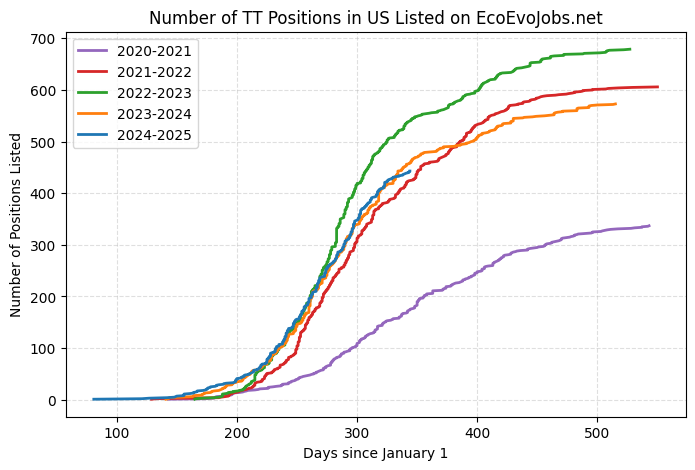

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))

for (year, dfy), color in zip(dfs_cleaned.items(), colors):
    ax.plot(dfy['day_of_season'], dfy['running_count'], label=year, color=color, linewidth=2)

ax.set_title("Number of TT Positions in US Listed on EcoEvoJobs.net")
ax.set_ylabel('Number of Positions Listed')
ax.set_xlabel('Days since January 1')
ax.legend(frameon=True)
ax.grid(**grid_params)
fig.savefig("figures/evoevojobs.pdf")
fig.savefig("figures/evoevojobs.png")

In [14]:
evol_gen_fields = [
    "Evolutionary Biology",
    "Genetics",
    "Evolutionary Genetics", 
    "Human Genetics",
    "Population Genetics",
    "Conservation Genetics",
    "Evolutionary Genomics",
    "Molecular Evolution",
    "Evolution",
    "Genetics/Genomics",
    "Evolutionary Developmental Biology",
    "Molecular Genetics",
    "Population Genetics",    
    "Population Genomics",
    "Evolution and Genetics",
    "Evolutionary Physiology",
]

In [15]:
dfs_cleaned = combine_and_clean_data(dfs, filters=[pl.col('subject_area').is_in(evol_gen_fields)])

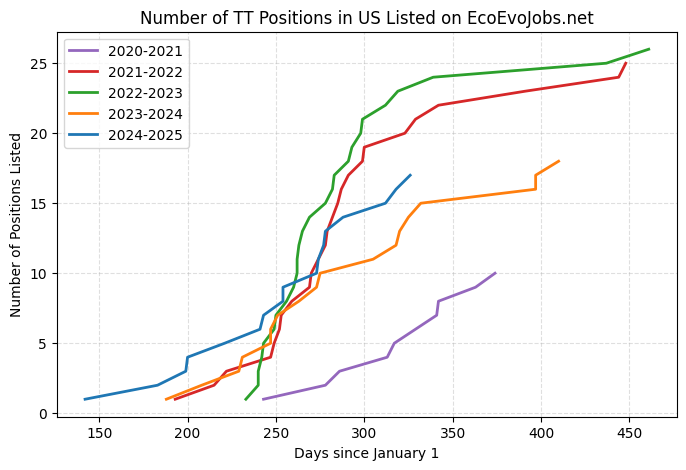

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))

for (year, dfy), color in zip(dfs_cleaned.items(), colors):
    ax.plot(dfy['day_of_season'], dfy['running_count'], label=year, color=color, linewidth=2)

ax.set_title("Number of TT Positions in US Listed on EcoEvoJobs.net")
ax.set_ylabel('Number of Positions Listed')
ax.set_xlabel('Days since January 1')
ax.legend(frameon=True)
ax.grid(**grid_params)
fig.savefig("figures/evolgen_evoevojobs.pdf")
fig.savefig("figures/evolgen_evoevojobs.png")